<a href="https://colab.research.google.com/github/sammetakushal159/Text-Classification/blob/main/Sentiment_Analysis_using_GloVe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import os
from keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt
import re
from sklearn.model_selection import train_test_split
from keras.backend import concatenate
from keras import Sequential
from keras import layers
from keras import models
from keras.layers import Embedding,Conv2D,MaxPooling2D,Dense,Flatten,AveragePooling1D
from keras.layers import Conv2DTranspose,UpSampling2D,Dropout
from keras.layers import Conv1D,MaxPooling1D
from keras.layers import Conv1DTranspose,UpSampling1D
from keras.callbacks import ModelCheckpoint,EarlyStopping,CSVLogger
from traitlets.traitlets import validate
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sn

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
GloVe = "/content/drive/MyDrive/glove.6B.100d.txt"

In [ ]:
max_len = 256
embedding_dim = 100
max_words = 400000

In [ ]:
datadir = "/content/drive/MyDrive/twitter_data.csv"

data = pd.read_csv(datadir,encoding='latin-1',names=["sentiment" ,"id", "date","No_query","@mention","text"])

data = data.sample(frac = 1)

In [ ]:
data.drop('id', axis=1, inplace=True)
data.drop('date', axis=1, inplace=True)
data.drop('No_query', axis=1, inplace=True)
data.drop('@mention', axis=1, inplace=True)
data.head(5)

,sentiment,text
156251,0,@rucha_334 but I couldn't follow them as I hav...
1179769,4,http://bit.ly/nx3pM . &lt;--My Zeeshirts busin...
1390023,4,@langwitches - That sounds v. nice
1147097,4,Just saw Hugh Jackman's ass. And today was a g...
1213832,4,@themosaicist yeap! and this year's kumang gaw...


In [ ]:
data['senti']=data['sentiment'].apply(lambda x: 1 if x==4 else 0)

In [ ]:
def text_cleaning(text):
  text = re.sub(r'@[A-Za-z0-9]+', '', text)                         # removing @mentions
  text = re.sub(r'@[A-Za-zA-Z0-9]+', '', text)                      # removing @mentions
  text = re.sub(r'@[A-Za-z-_]+', '', text)                          # removing @mentions
  text = re.sub(r'@[-_]+', '', text)                                # removing @mentions
  text = re.sub(r'#', '', text )                                    # removing '#' sign
  text = re.sub(r'RT[\s]+', '', text)                               # removing RT
  text = re.sub(r'https?\/\/\S+', '', text)                         # removing the hyper link
  text = re.sub(r'(?:\@|http?\://|https?\://|www)\S+', '', text)    # removing the hyper link
  text = re.sub(r'http?\/\/\S+', '', text)                          # removing the hyper link
  text = re.sub(r'&[a-z;]+', '', text)                              # removing '&gt;'

  return text

In [ ]:
data['text'] = data['text'].apply(text_cleaning)
data.head(10)

,sentiment,text,senti
156251,0,_334 but I couldn't follow them as I have reac...,0
1179769,4,. --My Zeeshirts business update! Support me ...,1
1390023,4,- That sounds v. nice,1
1147097,4,Just saw Hugh Jackman's ass. And today was a g...,1
1213832,4,yeap! and this year's kumang gawai is... ME!!...,1
639506,0,It's hot i can't sleep,0
158641,0,Waking up nauseous and with and headache... nice,0
912249,4,"was in Palawan a couple of days ago, i'll try ...",1
1104568,4,At work till 11am and then to ALC premier loca...,1
1066042,4,the best luck from your fans it isn't late....,1


In [ ]:
texts = data['text']
labels = data['senti']

In [ ]:
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index

data_fi = keras.preprocessing.sequence.pad_sequences(sequences, maxlen=max_len,padding='post')

In [ ]:
voc_size = len(tokenizer.word_index) +1
print(voc_size)

319266


In [ ]:
X_train,X_test,Y_train,Y_test = train_test_split(data_fi,labels,test_size=0.2)

X_test,X_val,Y_test,Y_val = train_test_split(X_test,Y_test,test_size=0.5)

In [ ]:
embedding_index = {}

f = open(GloVe, encoding="utf8")
for line in f:
  values = line.split()
  word = values[0]
  coefs = np.asarray (values [1:], dtype= 'float32')
  embedding_index[word] =  coefs
f.close ()

In [ ]:
embedding_matrix = np.zeros((voc_size, embedding_dim))

for word,i in word_index.items():
  embedding_vector = embedding_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

In [ ]:
model = Sequential ()
model.add(Embedding(voc_size, embedding_dim, input_length=max_len))
model.add(Conv1D(filters=64, kernel_size=(5) ,activation='relu'))
model.add(Conv1D(filters=32, kernel_size=(3) ,activation='relu'))
model.add(Conv1D(filters=16, kernel_size=(1) ,activation='relu'))
model.add(Flatten ())
#model.add(Dense (32, activation='relu'))
model.add(Dense (1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 256, 100)          31926600  
                                                                 
 conv1d (Conv1D)             (None, 252, 64)           32064     
                                                                 
 conv1d_1 (Conv1D)           (None, 250, 32)           6176      
                                                                 
 conv1d_2 (Conv1D)           (None, 250, 16)           528       
                                                                 
 flatten (Flatten)           (None, 4000)              0         
                                                                 
 dense (Dense)               (None, 1)                 4001      
                                                                 
Total params: 31,969,369
Trainable params: 31,969,369
No

In [ ]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [ ]:
METRICS = [tf.keras.metrics.BinaryAccuracy(name='accuracy'),tf.keras.metrics.Precision(name='precision'),tf.keras.metrics.Recall(name='recall')]

model.compile(optimizer='adam',loss='binary_crossentropy',metrics=METRICS)

In [ ]:
history = model.fit(X_train,Y_train,validation_data=(X_val,Y_val),epochs=10)

Epoch 1/10
40000/40000 [==============================] - 191s 4ms/step - loss: 0.4815 - accuracy: 0.7680 - precision: 0.7615 - recall: 0.7803 - val_loss: 0.4542 - val_accuracy: 0.7884 - val_precision: 0.7957 - val_recall: 0.7769
Epoch 2/10
40000/40000 [==============================] - 176s 4ms/step - loss: 0.4484 - accuracy: 0.7903 - precision: 0.7819 - recall: 0.8049 - val_loss: 0.4451 - val_accuracy: 0.7908 - val_precision: 0.7682 - val_recall: 0.8339
Epoch 3/10
40000/40000 [==============================] - 184s 5ms/step - loss: 0.4376 - accuracy: 0.7968 - precision: 0.7881 - recall: 0.8117 - val_loss: 0.4417 - val_accuracy: 0.7920 - val_precision: 0.7662 - val_recall: 0.8413
Epoch 4/10
40000/40000 [==============================] - 178s 4ms/step - loss: 0.4310 - accuracy: 0.8007 - precision: 0.7923 - recall: 0.8147 - val_loss: 0.4353 - val_accuracy: 0.7971 - val_precision: 0.7905 - val_recall: 0.8091
Epoch 5/10
40000/40000 [==============================] - 177s 4ms/step - loss: 

In [ ]:
y_predicted = model.predict(X_test)

5000/5000 [==============================] - 9s 2ms/step


In [ ]:
y_predicted = y_predicted.flatten()
y_predicted = np.where(y_predicted > 0.5, 1, 0)

Text(50.722222222222214, 0.5, 'Truth')

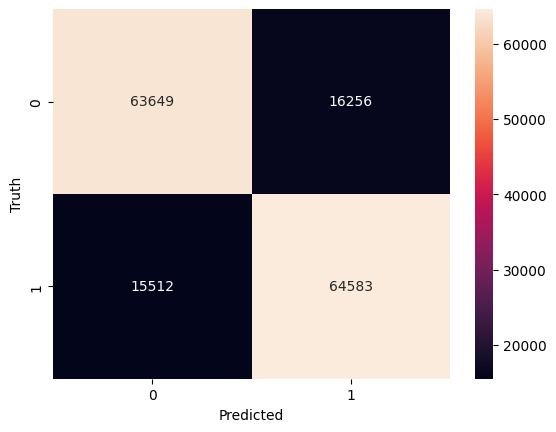

In [ ]:
cm = confusion_matrix(Y_test, y_predicted)

sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')